## Actual Machine Learning Section

This is the file that handles all the machine learning elements of this project. First, we train a Random Forest Classifier from SKLearn with 256 trees on the data for fluxes, which has a **64%** accuracy. This already beats manual selection by about **20%** accuracy. We also use a Convolutional Neural Network on the images to classify then as orange, white, or blue, which it does with about **80%** accuracy. Finally, a multi-layer perceptron takes the probabilities from the CNN and the predictions from the Random Forest and combines them, resulting in a final accuracy of **95%**.

### If some things fail to import, then you need to use the most recent packages on the latest python version possible.

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import os 
import joblib

LabelEncoding, images_to_ignore = LabelEncoder(), (7, 8, 10, 25, 28, 33, 36, 59, 60, 64, 69, 73, 79, 80, 81, 87, 99, 100, 102, 105, 106, 108, 116, 118, 124, 131, 139, 145, 146, 158, 162, 174, 178, 190, 199, 203, 205, 215, 241, 242, 262, 271, 273, 275, 279, 283, 285, 287, 291, 293, 306, 316, 317, 323, 328, 329, 333, 336, 339, 348)

#Sets up label encoding. The images-to-ignore list contains a list of the image names (Star{NUM}) to ignore because they were particularly noisy or bad images that would only serve to throw off the model. 

2023-08-10 13:10:50.306605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 13:10:51.508238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DATASET_PATH, IMAGE_DATASET = os.path.join('Dataset', 'Dataset.csv'), os.path.join('Image Dataset') #Sets up the path to the datasets

if os.path.exists(DATASET_PATH) and os.path.exists(IMAGE_DATASET): #If both paths exist, print to continue
    print('The Dataset is set up properly')

if not os.path.exists(DATASET_PATH): #Stops if regular dataset of fluxes has not been created
    print('FULL STOP! Dataset has not been created!')

if not os.path.exists(IMAGE_DATASET): #Stops if image dataset has not been created
    print('FULL STOP! Image Dataset has not been created!')

The Dataset is set up properly


### The following lines of code split the data into train, validation, and test data

Because there are three separate models, there needs to be two different types of inputs for the first two models (evaluate based on image and evaluate based on fluxes). These are PREFIX image and PREFIX x/y. The final model will take inputs from these two models so it just needs the full spectral classification labels, indicated by PREFIX full_labels. 

In [3]:
image_x, num_stars = [], len(os.listdir(IMAGE_DATASET)) #Num_Stars obtained from getting the number of files in the Image Dataset

full_labels = keras.utils.to_categorical(LabelEncoding.fit_transform(pd.read_csv(DATASET_PATH, index_col=0)['Spectral Class'][:num_stars].drop(np.array(images_to_ignore) - 1).to_numpy()), 7)
#pd.read_csv() reads the CSV file (THESE ARE LABELS OF FINAL SPECTRAL CLASS) and turns it into a pandas DataFrame. ['Spectral Class'] pulls only the spectral class column, and the [:num_stars] makes sure to only pull labels until the number of stars (don't pull more than that). .drop() drops the stars that we don't want, fit_transform turns this to integers, then to_categorical one-hot encodes this.

image_y = keras.utils.to_categorical(pd.read_csv(os.path.join('Images', 'ImageClassification.csv'), index_col=0).iloc[:num_stars, :].drop(np.array(images_to_ignore) - 1).to_numpy(), 3)
#pd.read_csv() reads the CSV file (THESE ARE LABELS OF ORANGE, BLUE, OR WHITE) and turns it into a pandas DataFrame. .iloc[:num_stars, :], only takes the classifications that are completed up to the number of images. .drop() drops the stars that we don't want, fit_transform turns this to integers, then to_categorical one-hot encodes this.

for i in range(1, num_stars+1): #For the star indices as saved in the Image Dataset folder
    if i not in images_to_ignore: #If the index is not in the indices to ignore
        image_x.append(img_to_array(load_img(os.path.join(IMAGE_DATASET, f'Star{i}.png')))) #Append the matrix representation of the image to image_x

image_x = np.array(image_x)

NUM_RESERVED = 64 #64 is the number of images in the test and validation set, adjust this number to increase or decrease the number of items in the image validation dataset
TEST_SPLIT = len(image_x) - 64 
VAL_SPLIT = len(image_x) - NUM_RESERVED*2

image_x, image_val_x, image_test_x = image_x[:VAL_SPLIT], image_x[VAL_SPLIT:TEST_SPLIT], image_x[TEST_SPLIT:]
image_y, image_val_y, image_test_y = image_y[:VAL_SPLIT], image_y[VAL_SPLIT:TEST_SPLIT], image_y[TEST_SPLIT:]
full_labels, full_labels_val, full_labels_test = full_labels[:VAL_SPLIT], full_labels[VAL_SPLIT:TEST_SPLIT], full_labels[TEST_SPLIT:]
#MANUALLY SET TEST SIZE TO MAKE COMBINATION of DATASETS EASY (CHANGE WHENEVER YOU ADD MORE DATA)

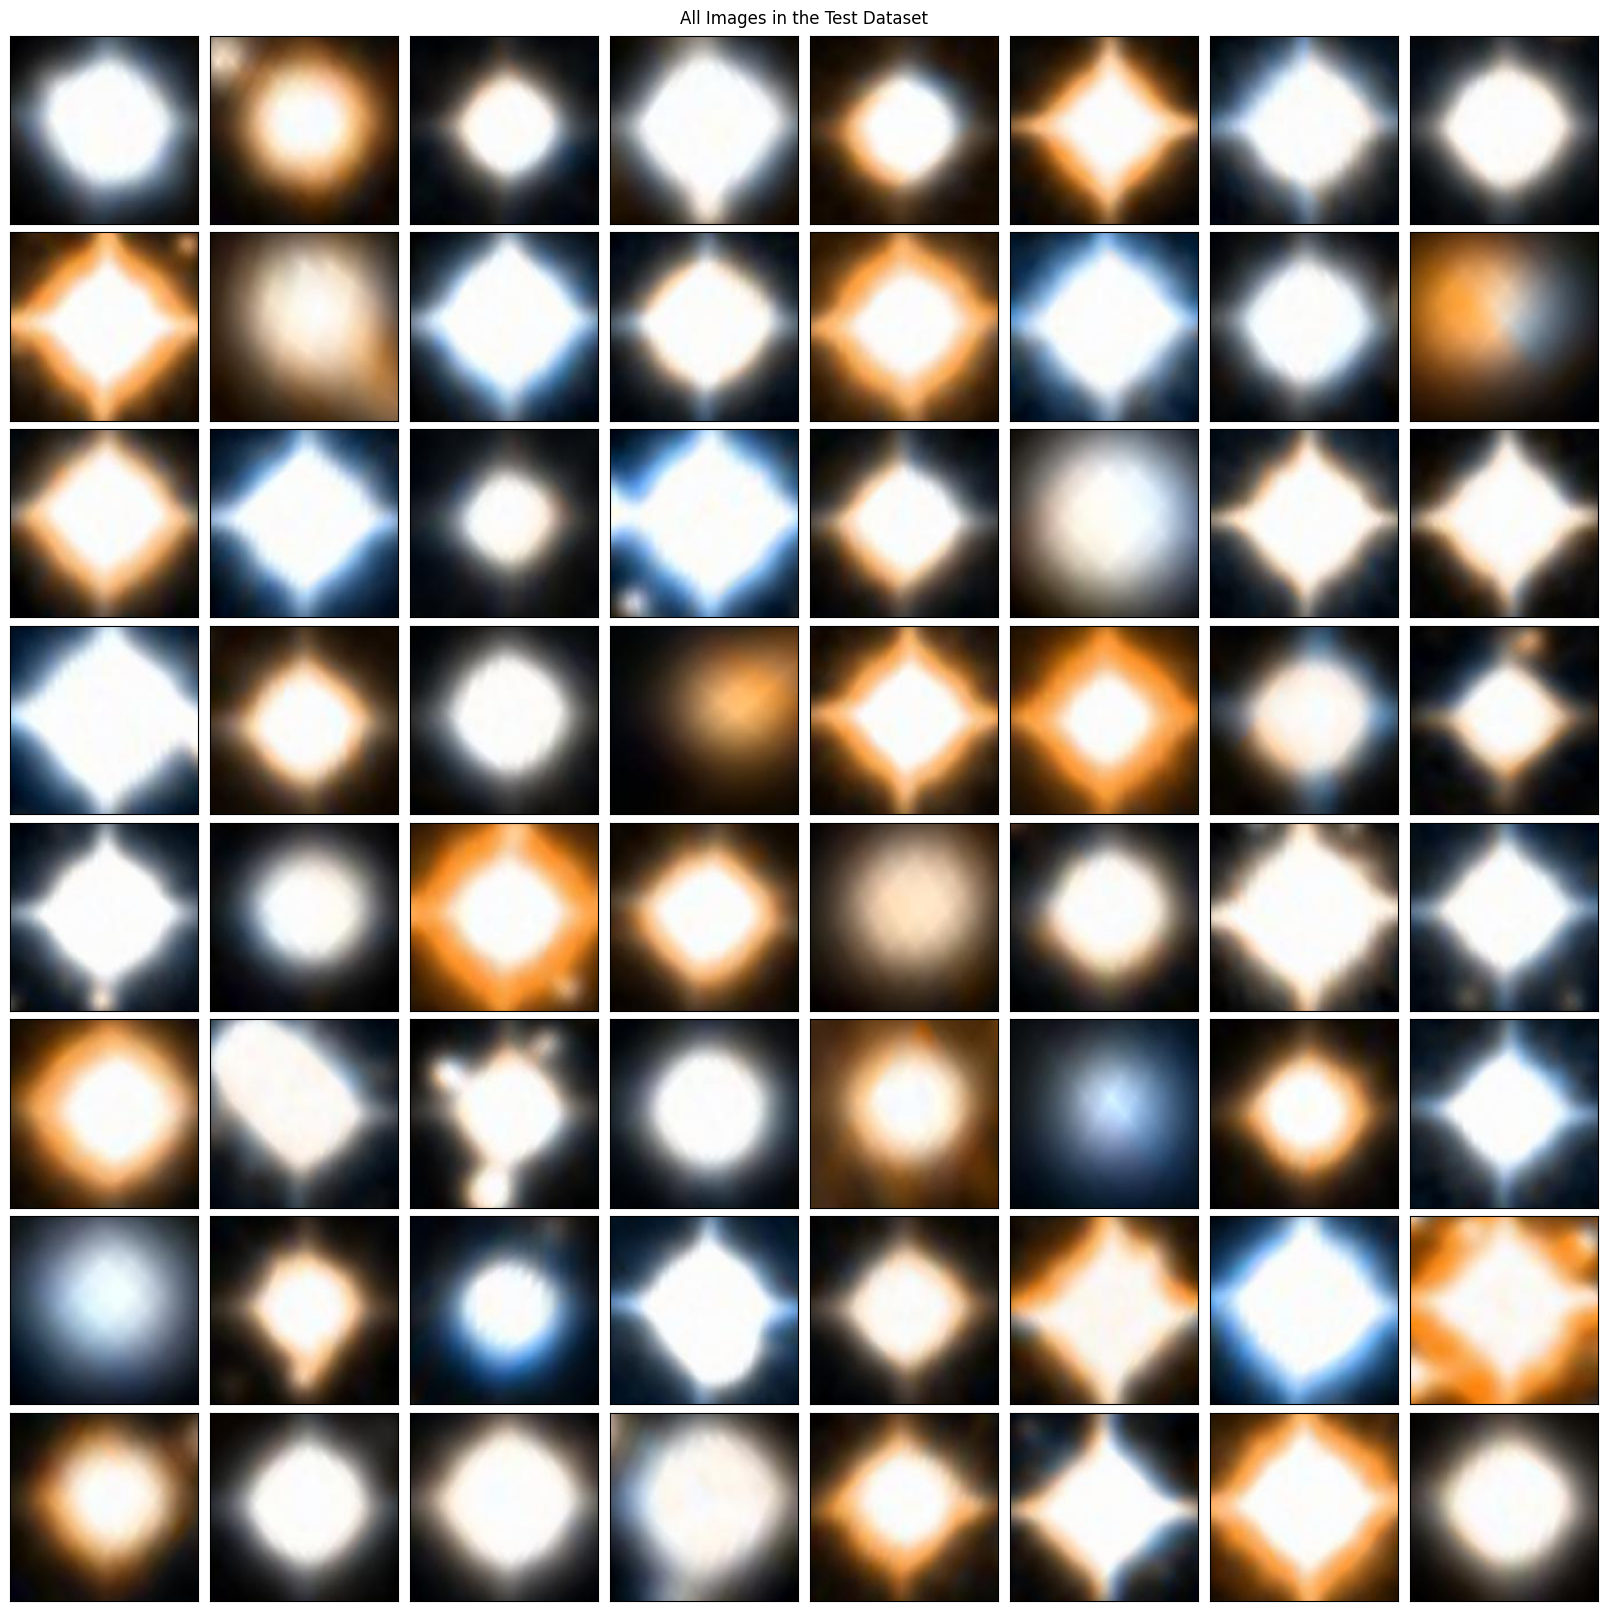

In [4]:
figure, axs = plt.subplots(8, 8, figsize=(16, 16), layout='constrained') 

for ax, image in zip(axs.flatten(), image_test_x): #Plots every single image using IMSHOW and gets rid of the ticks for better viewing
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    ax.imshow(image.astype('int64'))

figure.suptitle('All Images in the Test Dataset')
plt.show()

### Random Forest Classifier 

We use a random forest classifier on the data with fluxes, and it has 256 trees. We import the data from the Dataset.csv file, and we train the model over the full 7000 stars we obtained from Simbad (without images). This obtains a **64%** accuracy by itself when evaluated on the test split.

In [5]:
DSet = pd.read_csv(DATASET_PATH, index_col=0) #Loading the Text Dataset
x, y = DSet.iloc[:, 1:], DSet['Spectral Class'] #Splitting into Labels and the rest of the Data

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, random_state=24, test_size=0.2) #Train/Test Splitting

if not os.path.exists(os.path.join('RandomForest.joblib')): #If saved path does not exist
    RandomForest = RandomForestClassifier(256, criterion='entropy', verbose=1) #Random Forest Classifier with entropy

    RandomForest.fit(x_train, y_train) #Fit Random Forest to Data and then save
    joblib.dump(RandomForest, os.path.join('RandomForest.joblib'))

else:
    RandomForest = joblib.load(os.path.join('RandomForest.joblib')) #If saved file is present, load the saved file

In [6]:
predictions = RandomForest.predict(x_test) #Find accuracy by predictions
print(f'Accuracy is: {accuracy_score(y_test, predictions)}')

Accuracy is: 0.6414285714285715


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


### Convolutional Neural Network 

We use a Convolutional Neural Network to evaluate the images. This is useful because the model returns whether the star is orange, blue, or white, which helps the final model on its evaluation of the actual type of the star. This CNN has about **80%** accuracy.

In [7]:
data_augment = keras.Sequential( #Augment data to make sure the model is trained on as much data as possible
    [
        keras.layers.RandomFlip(), #Randomly flip horizontal or vertical to augment the data
        keras.layers.RandomRotation(0.2*np.pi), #Randomly rotate to augment the image
    ]
)

def createmodel1():
    input_layer = keras.Input(shape=(164, 164, 3)) #Input shape of matrix will be (164, 164, 3) because the image is RGB
    x = data_augment(input_layer) #Apply the data augmentation
    x = keras.layers.Rescaling(1./255)(x) #Rescale the RGB values to [0, 1] so that the model can more easily train on these

    x = keras.layers.Conv2D(6, (3, 3))(x) #Two dimensional convolutional layer
    x = keras.layers.MaxPool2D()(x)

    x = keras.layers.Conv2D(8, (3, 3))(x) #Two dimensional convolutional layer
    x = keras.layers.MaxPool2D()(x)

    x = keras.layers.Flatten()(x) #Flatten in preparation for inputting into the Dense network
    x = keras.layers.Dense(512, activation='elu')(x) #Dense layer
    output_layer = keras.layers.Dense(3, activation='softmax')(x) #Output layer with 3 categories (Orange, Blue, White)

    model1 = keras.Model(input_layer, output_layer, name='CNN') #Make the model
    optimizer = keras.optimizers.AdamW(learning_rate=1e-4) #Make optimizer (AdamW for better generalization)
    model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #Compile the model

    return model1

if not os.path.exists(os.path.join('CNN.keras')):
    model1 = createmodel1()

    history = model1.fit(image_x, image_y, batch_size=1, verbose=1, validation_data=(image_val_x, image_val_y), epochs=60) #Train the new model
    keras.utils.plot_model(model1, os.path.join('Images', 'CNN.png')) #Plot and save plot of CNN model

    figure, (ax1, ax2) = plt.subplots(2, 1, layout='constrained')

    ax1.plot(history.history['loss'], 'b-', label='Loss') #Plot Loss and Validation loss vs the number of epochs
    ax1.plot(history.history['val_loss'], 'g-', label='Validation Loss')
    ax1.set(xlabel='Number of Epochs', ylabel='Loss (Categorical Crossentropy)', title='Loss vs Number of Epochs')
    ax1.legend()

    ax2.plot(history.history['accuracy'], 'b-', label='Accuracy') #Plot Accuracy and Validation accuracy vs the number of epochs
    ax2.plot(history.history['val_accuracy'], 'g-', label='Validation Accuracy')
    ax2.set(xlabel='Number of Epochs', ylabel='Accuracy', title='Accuracy vs Number of Epochs')
    ax2.legend()

    figure.suptitle('Accuracy and Loss vs Number of Epochs') #Add title and save the figure
    figure.savefig(os.path.join('Images', 'Loss Diagram'))

    model1.save(os.path.join('CNN.keras')) #Save the model as CNN.keras
    model1.save_weights(os.path.join('CNN.h5')) #Save model weights for OS compatibility

    model1.evaluate(image_test_x, image_test_y) #Evaluate model on tests
    
elif os.path.exists(os.path.join('CNN.keras')):
    try:
        model1 = keras.models.load_model(os.path.join('CNN.keras')) #Load the keras model
    
    except:
        model1 = createmodel1() #Create and load keras model with weights if this above line of code does not work
        model1.load_weights(os.path.join('CNN.h5'))
    
    model1.evaluate(image_test_x, image_test_y) #Evaluate model on tests

2023-08-10 13:10:59.881833: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-08-10 13:10:59.881900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: pop-os
2023-08-10 13:10:59.881906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: pop-os
2023-08-10 13:10:59.881994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.86.5
2023-08-10 13:10:59.882013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.86.5
2023-08-10 13:10:59.882019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.86.5


2/2 [==============================] - 0s 22ms/step - loss: 0.4668 - accuracy: 0.8125


### Final Model Data Handling

The below cell handles the data for the Final model. It first gets the fluxes from the dataset, then splits them and then evaluates them on the Random Forest. Then, it gets the predictions of the CNN on the images and stores them.

In [8]:
fluxes = pd.read_csv(DATASET_PATH, index_col=0).iloc[:num_stars, 1:].drop(np.array(images_to_ignore) - 1) #Load CSV Dataset.csv. .iloc[:num_stars, 1:] ensures that only fluxes are read and that only fluxes that are within the number of stars are read. .drop() drops the bad images, or the images to ignore
train_fluxes, val_fluxes, test_fluxes = fluxes.iloc[:VAL_SPLIT, :], fluxes.iloc[VAL_SPLIT:TEST_SPLIT, :], fluxes.iloc[TEST_SPLIT:, :] #Splits into seperate training data
train_fluxes, val_fluxes, test_fluxes = RandomForest.predict_proba(train_fluxes), RandomForest.predict_proba(val_fluxes), RandomForest.predict_proba(test_fluxes) #Predicts using Random Forest the fluxes, which is then fed to the final model.

train_image_predictions, val_image_predictions, test_image_predictions = model1.predict(image_x), model1.predict(image_val_x), model1.predict(image_test_x) #Predicts using the CNN the images, which is then fed to the final model.

1/6 [====>.........................] - ETA: 0s

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


2/2 [==============================] - 0s 20ms/step


### Final Model 

This is the final model that is a simple multi-layer perceptron model. This combines the outputs given by the CNN and the Random Forest to give a final prediction. This model is about **95%** accurate.

In [9]:
FINAL = os.path.join('Final.keras')

def createmodel2(): 
    input_image, input_fluxes = keras.Input(shape=(3, 1), name='Image Input'), keras.Input(shape=(7, 1), name='Flux Input') #Take the multiple inputs, first with the image input of probabilities and then the input of the fluxes.

    cocatenate = keras.layers.Concatenate(axis=1)([input_image, input_fluxes]) #Cocatenate these to combine them into one vector to pass on.

    x = keras.layers.Flatten()(cocatenate) #Flatten the Cocatenation layer for the Dense Network
    x = keras.layers.Dense(125, activation='elu', kernel_regularizer='L2', activity_regularizer='L2')(x) #Dense Network with Dropout.
    x = keras.layers.Dropout(0.6)(x)
    x = keras.layers.Dense(52, activation='elu', kernel_regularizer='L2', activity_regularizer='L2')(x)
    x = keras.layers.Dropout(0.7)(x)

    output_layer = keras.layers.Dense(7, activation='softmax', name='Probability')(x) #Output 7 probabilities representing the possible spectral classes

    model2 = keras.Model(inputs=[input_image, input_fluxes], outputs=output_layer, name='Combination') 

    optimizer = keras.optimizers.AdamW(learning_rate=1e-4) #AdamW optimizer
    model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #Compiles model

    return model2

if not os.path.exists(FINAL):
    model2 = createmodel2()

    history = model2.fit([train_image_predictions, train_fluxes], full_labels, batch_size=1, verbose=1, validation_data=([val_image_predictions, val_fluxes], full_labels_val), epochs=300) #Training model

    figure, (ax1, ax2) = plt.subplots(2, 1, layout='constrained')

    ax1.plot(history.history['loss'], 'b-', label='Loss') #Plot Loss and Validation loss vs the number of epochs
    ax1.plot(history.history['val_loss'], 'g-', label='Validation Loss')
    ax1.set(xlabel='Number of Epochs', ylabel='Loss (Categorical Crossentropy)', title='Loss vs Number of Epochs')
    ax1.legend()

    ax2.plot(history.history['accuracy'], 'b-', label='Accuracy') #Plot Accuracy and Validation accuracy vs the number of epochs
    ax2.plot(history.history['val_accuracy'], 'g-', label='Validation Accuracy')
    ax2.set(xlabel='Number of Epochs', ylabel='Accuracy', title='Accuracy vs Number of Epochs')
    ax2.legend()

    figure.suptitle('Accuracy and Loss vs Number of Epochs') #Add title and save the figure
    figure.savefig(os.path.join('Images', 'Loss Diagram 2'))

    keras.utils.plot_model(model2, os.path.join('Images', 'Final.png')) #Plot and save plot of Final model
    model2.save(FINAL)
    model2.save_weights(os.path.join('Final.h5'))

    model2.evaluate([test_image_predictions, test_fluxes], full_labels_test) #Evaluate model on test data

elif os.path.exists(FINAL):
    try:
        model2 = keras.models.load_model(FINAL)
        
    except:
        model2 = createmodel2()
        model2.load_weights(os.path.join('Final.h5'))
    
    model2.evaluate([test_image_predictions, test_fluxes], full_labels_test) #Evaluate model on test data

2/2 [==============================] - 0s 2ms/step - loss: 0.3871 - accuracy: 0.9531


### Visualization of Stars and Model Accuracy

The below cell will visualize the stars and the model accuracy, it will display the star image and then the predicted probabilities of the model along with the true star type.

In [10]:
test_predictions, SPEC_TYPES = model2.predict([test_image_predictions, test_fluxes]), ('A', 'B', 'F', 'G', 'K', 'M', 'O') #Predict with model and set up Spectral types

valid_viewing = False 
while not valid_viewing:
    how_many_images = input('How many images out of the test dataset and predictions do you want to view(integer)') #Get from the user how many images they want to view

    try:
        how_many_images, valid_viewing = int(how_many_images), True 
    
    except:
        print('You must enter a valid integer!')

num_stars = 1
for prediction, label, image in zip(test_predictions, LabelEncoding.inverse_transform(np.argmax(full_labels_test, axis=1)), image_test_x): #Iterates over every possible test image, and the inverse transform combined with argmax transforms the labels back into readable text

    if num_stars <= how_many_images: #Makes sure that the program displays an equal number of images as the user requested
        figure, (ax1, ax2) = plt.subplots(1, 2, layout='tight')

        ax1.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
        ax1.imshow(image.astype('int64')) #Display image in RGB with matplotlib
        ax1.set_title('Star Image')

        ax2.bar(SPEC_TYPES, prediction) #Bar graph of probabilities
        ax2.set(xlabel='Spectral types', ylabel='Probability Predicted', title='Probability Predicted by Model')

        figure.suptitle(f'Star {num_stars}: Type {label}')
        num_stars += 1 #Update the number of stars

        plt.show()
    
    else:
        break

2/2 [==============================] - 0s 2ms/step


### The below cell visualizes the total accuracy of the model across all the data

2/2 [==============================] - 0s 1ms/step


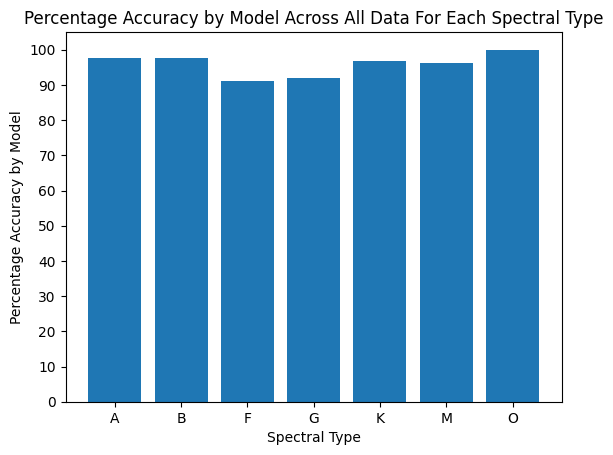

In [11]:
train_predict, validation_predict = np.argmax(model2.predict([train_image_predictions, train_fluxes]), axis=1), np.argmax(model2.predict([val_image_predictions, val_fluxes]), axis=1) #Takes the predictions of the model, turns them back into integer encoding based upon the size 
all_predictions, all_labels = LabelEncoding.inverse_transform(np.concatenate([train_predict, validation_predict, np.argmax(test_predictions, axis=1)])), LabelEncoding.inverse_transform(np.argmax(np.concatenate([full_labels, full_labels_val, full_labels_test]), axis=1)) #Concatenates all predictions into one so that we can iterate through to create the histogram, converts them back to our original text form using argmax and inverse_transform

spec_type_dict = {'A': [0, 0], 'B': [0, 0], 'F': [0, 0], 'G': [0, 0], 'K': [0, 0], 'M': [0, 0], 'O': [0, 0]} #Sets up dictionary to get proportions for percentages
for prediction, label in zip(all_predictions, all_labels):

    if prediction == label: #If prediction is correct, add one to the left side of the list in the dictionary, which is number of correct predictions
        spec_type_dict[label][0] += 1
    
    spec_type_dict[label][1] += 1 #No matter what, addd one to the right side of the list in the dictionary, which indicates the count of predictions made

for key, item in spec_type_dict.items():
    spec_type_dict[key] = item[0]/item[1]*100 #Turns everything into a percentage from the lists in the dictionary

SpecTypeUnpacked = spec_type_dict.items()
SPEC_TYPES, PERCENTAGE_ACCURACY = [item[0] for item in SpecTypeUnpacked], [item[1] for item in SpecTypeUnpacked] #Gets the spectral types and the percentage accuracy separately 

plt.bar(SPEC_TYPES, PERCENTAGE_ACCURACY)
plt.xlabel('Spectral Type')
plt.ylabel('Percentage Accuracy by Model')
plt.title('Percentage Accuracy by Model Across All Data For Each Spectral Type')
plt.yticks(ticks=list(range(0, 110, 10)), labels=list(range(0, 110, 10)))

plt.savefig(os.path.join('Images', 'ModelAccuracy.png'))